# Heston stochastic volatility (QE) — implied-vol smile and surface

This notebook demonstrates Heston Monte Carlo pricing with a QE scheme and extracts implied volatilities to visualize the smile and surface.

Scope and framing:
- **Qualitative**: the goal is intuition, not calibration.
- **Model-generated**: outputs are synthetic and not a backtest.
- **Risk-neutral pricing**: focus is on implied-vol structure, not realized returns.


**Reading guide**

1. **Sanity check the paths** to confirm the simulation behaves sensibly.
2. **Build smiles** at fixed maturities to see skew/curvature.
3. **Render the surface** to understand maturity-strike structure.
4. **Stress a key parameter (`rho`)** to see how skew responds.

Figures are saved to `figures/60_heston_smile_and_surface/` with stable filenames.


In [ ]:
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt

import importlib

from src import heston as heston_mod
from src import implied_vol as implied_vol_mod

project_root = Path.cwd().parent
sys.path.append(str(project_root))

importlib.reload(heston_mod)
importlib.reload(implied_vol_mod)

simulate_heston_qe_paths = heston_mod.simulate_heston_qe_paths
price_european_option_heston_mc = heston_mod.price_european_option_heston_mc
bs_implied_vol = implied_vol_mod.bs_implied_vol
implied_vol_surface = implied_vol_mod.implied_vol_surface

fig_dir = project_root / "figures" / "60_heston_smile_and_surface"
fig_dir.mkdir(parents=True, exist_ok=True)

# Parameters (edit freely)
S0 = 100.0
r = 0.01
v0 = 0.04
kappa = 2.0
theta = 0.04
xi = 0.7
rho = -0.6

maturities = np.array([1 / 12, 3 / 12, 6 / 12])
strikes = np.linspace(70, 130, 13)

n_steps = 60
n_paths = 20000
seed = 123

sample_paths = 8
sample_seed = 7

## 1) Path sanity checks

We first simulate Heston paths to verify:
- Price paths remain positive and behave smoothly.
- Variance paths are mean-reverting and stay non-negative under the QE scheme.
- Summary statistics (means, percentiles) are in a plausible range.

If these checks fail, implied-vol plots are not meaningful.


**Why this step matters**

Implied-vol surfaces are only as reliable as the underlying path simulation. If variance paths drift negative or explode, the smile will reflect numerical artifacts rather than model behavior.


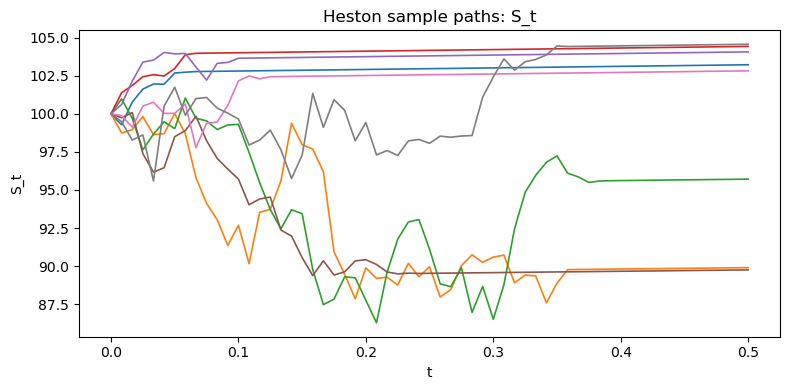

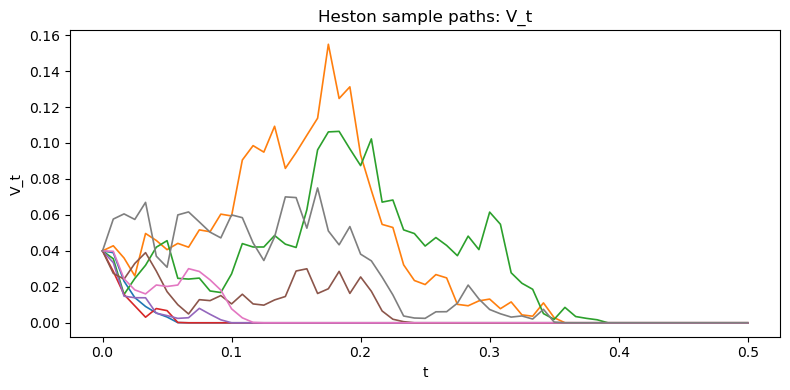

In [2]:
t_grid, s_paths, v_paths = simulate_heston_qe_paths(
    S0=S0,
    v0=v0,
    r=r,
    kappa=kappa,
    theta=theta,
    xi=xi,
    rho=rho,
    T=maturities[-1],
    n_steps=n_steps,
    n_paths=sample_paths,
    seed=sample_seed,
)

plt.figure(figsize=(8, 4))
for i in range(sample_paths):
    plt.plot(t_grid, s_paths[i], lw=1.2)
plt.title("Heston sample paths: S_t")
plt.xlabel("t")
plt.ylabel("S_t")
plt.tight_layout()
plt.savefig(fig_dir / "heston_sample_paths_S.png", dpi=160)
plt.show()

plt.figure(figsize=(8, 4))
for i in range(sample_paths):
    plt.plot(t_grid, v_paths[i], lw=1.2)
plt.title("Heston sample paths: V_t")
plt.xlabel("t")
plt.ylabel("V_t")
plt.tight_layout()
plt.savefig(fig_dir / "heston_sample_paths_V.png", dpi=160)
plt.show()

### Note on implied volatility at short maturities

For deep out-of-the-money, short-dated options, Monte Carlo prices may be within numerical tolerance of intrinsic value. In this regime, Black–Scholes implied volatility is ill-defined or numerically unstable.

We therefore **mask** those points rather than forcing zeros or extrapolating. This keeps the smile/surface visually honest about numerical resolution limits.


## 2) Implied-vol smile at fixed maturities

We compute option prices across a grid of strikes at selected maturities and invert Black–Scholes to obtain implied volatilities.

Reading guide:
- Smiles are shown at a few representative maturities to highlight skew and curvature.
- Missing points correspond to masked implied vols (see the note above).


**Practical note**

Implied vol inversion is sensitive to price noise in the wings. If you see irregular points, increasing `n_paths` or smoothing across strikes can help, but this notebook keeps the workflow minimal by masking unstable points.


T=0.08y: 9 implied vols undefined (masked)
T=0.25y: 7 implied vols undefined (masked)
T=0.50y: 5 implied vols undefined (masked)


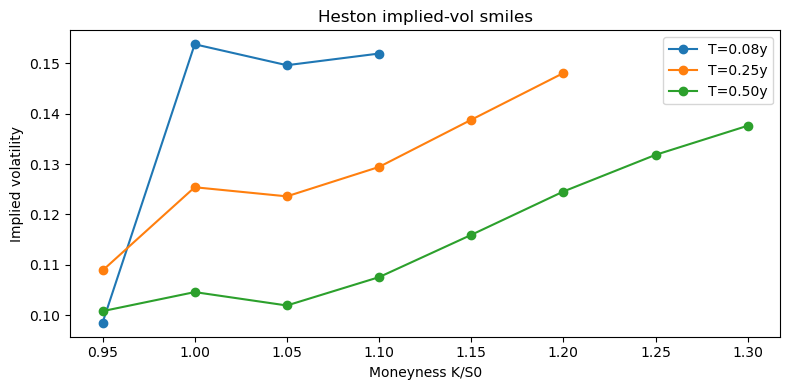

In [3]:
smiles = {}
for T in maturities:
    prices = []
    for K in strikes:
        price = price_european_option_heston_mc(
            option_type="call",
            S0=S0,
            K=float(K),
            T=float(T),
            r=r,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            n_steps=n_steps,
            n_paths=n_paths,
            seed=seed,
            return_ci=False,
        )
        prices.append(price)
    prices = np.asarray(prices)
    ivs = np.array(
        [
            bs_implied_vol(
                p,
                S0,
                float(K),
                float(T),
                r,
                option_type="call",
                price_eps_abs=1e-2,
                price_eps_rel=1e-10,
            )
            for p, K in zip(prices, strikes)
        ]
    )
    nan_count = int(np.sum(~np.isfinite(ivs)))
    if nan_count > 0:
        print(f"T={T:.2f}y: {nan_count} implied vols undefined (masked)")
    smiles[T] = ivs

plt.figure(figsize=(8, 4))
moneyness = strikes / S0
for T, ivs in smiles.items():
    mask = np.isfinite(ivs)
    plt.plot(moneyness[mask], ivs[mask], marker="o", label=f"T={T:.2f}y")
plt.title("Heston implied-vol smiles")
plt.xlabel("Moneyness K/S0")
plt.ylabel("Implied volatility")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "heston_iv_smile.png", dpi=160)
plt.show()

## 3) Implied-vol surface (heatmap)

We expand the smile calculation to a 2D grid of (maturity, strike) and plot a heatmap surface.

Look for:
- Term structure: how implied vol changes with maturity.
- Skew dynamics: how the slope varies across maturities.
- Curvature: how quickly implied vol rises in the wings.


**Surface intuition**

A consistent surface should show smooth transitions across both maturity and strike. Sharp discontinuities usually indicate numerical noise rather than true model features.


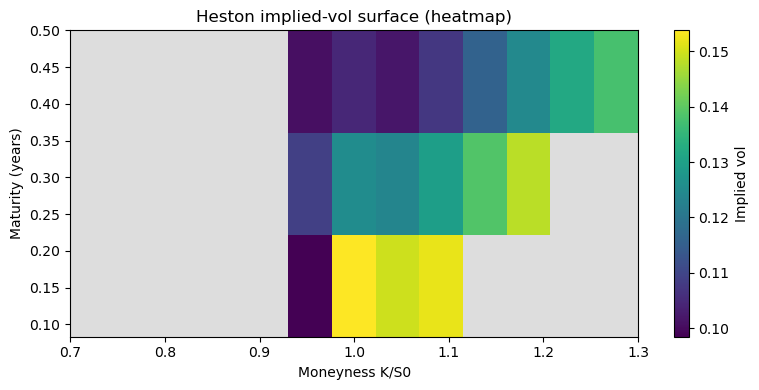

In [4]:
price_grid = np.empty((maturities.size, strikes.size))
for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        price_grid[i, j] = price_european_option_heston_mc(
            option_type="call",
            S0=S0,
            K=float(K),
            T=float(T),
            r=r,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho,
            n_steps=n_steps,
            n_paths=n_paths,
            seed=seed,
            return_ci=False,
        )

iv_surface = implied_vol_surface(
    price_grid,
    strikes=strikes,
    maturities=maturities,
    S0=S0,
    r=r,
    option_type="call",
    price_eps_abs=1e-2,
    price_eps_rel=1e-10,
)

iv_masked = np.ma.masked_invalid(iv_surface)
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="#dddddd")

plt.figure(figsize=(8, 4))
plt.imshow(
    iv_masked,
    origin="lower",
    aspect="auto",
    extent=[strikes[0] / S0, strikes[-1] / S0, maturities[0], maturities[-1]],
    cmap=cmap,
)
plt.colorbar(label="Implied vol")
plt.title("Heston implied-vol surface (heatmap)")
plt.xlabel("Moneyness K/S0")
plt.ylabel("Maturity (years)")
plt.tight_layout()
plt.savefig(fig_dir / "heston_iv_surface_heatmap.png", dpi=160)
plt.show()

## 4) Parameter sensitivity (rho)

We vary the correlation parameter `rho` to show its effect on skew.

Expected qualitative effect:
- More negative `rho` typically increases left-tail implied vol (equity-like skew).
- Near-zero `rho` often yields a more symmetric smile.


**Why focus on rho?**

In equity-style markets, negative spot/vol correlation is a dominant driver of skew. This section isolates that channel while holding other parameters fixed.


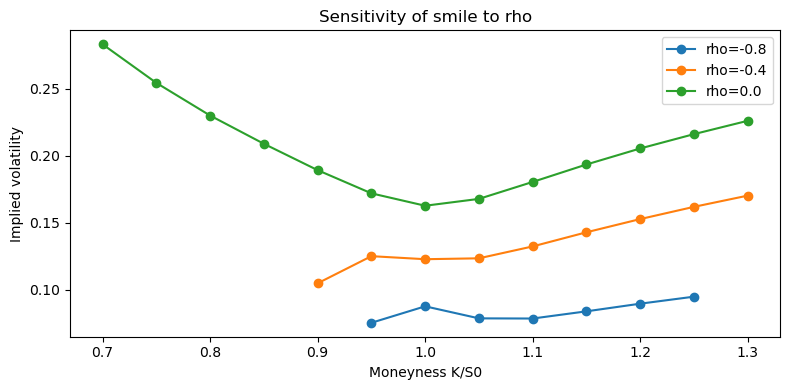

In [5]:
rho_values = [-0.8, -0.4, 0.0]
T_sens = 0.5

plt.figure(figsize=(8, 4))
for rho_sens in rho_values:
    prices = []
    for K in strikes:
        price = price_european_option_heston_mc(
            option_type="call",
            S0=S0,
            K=float(K),
            T=T_sens,
            r=r,
            v0=v0,
            kappa=kappa,
            theta=theta,
            xi=xi,
            rho=rho_sens,
            n_steps=n_steps,
            n_paths=n_paths,
            seed=seed,
            return_ci=False,
        )
        prices.append(price)
    prices = np.asarray(prices)
    ivs = np.array(
        [
            bs_implied_vol(p, S0, float(K), T_sens, r, option_type="call")
            for p, K in zip(prices, strikes)
        ]
    )
    plt.plot(strikes / S0, ivs, marker="o", label=f"rho={rho_sens:.1f}")

plt.title("Sensitivity of smile to rho")
plt.xlabel("Moneyness K/S0")
plt.ylabel("Implied volatility")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "heston_smile_sensitivity_rho_or_xi.png", dpi=160)
plt.show()

## Interpretation notes

- **Rho (correlation)**: negative values create equity-like downside skew.
- **Xi (vol of vol)**: higher values increase smile curvature and variability.
- **Kappa / theta**: control mean reversion and long-run variance, shaping term structure.

Limitations:
- No calibration (parameters are illustrative).
- Monte Carlo noise can be material at low path counts or short maturities.
- Heston assumes continuous paths and cannot capture jumps or discrete events.
